In [ ]:
import numpy as np 
# glob is used for manipulating files
import glob
import scipy

from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

import random

In [ ]:
# Finding all .csv files in the directory of this python script
files = glob.glob("/notebooks/smartwearable2025/*.csv")
# files = glob.glob("./*.csv")

In [ ]:
# Let's see the found files:
print(files)

In [ ]:
# Finding the number of classes (the number of classes is the number of files since we assume each file is for a different class)
num_classes = len(files)

# The number of channels is 6 for this dataset
num_channels = 6

In [ ]:
# Loading all the files into a list
data_per_class        = []
num_samples_per_class = []
num_windows_per_class = []

# Defining window length and step size
window_length     = 50
window_step_size  = 25

In [ ]:
# Loading the files and finding the number of samples and windows for each class
for file in files:
    data = np.loadtxt(file, delimiter=",")
    data_per_class.append(data) 
    num_samples = data.shape[0]
    num_samples_per_class.append(num_samples)
    num_windows = (num_samples - window_length) // window_step_size + 1
    num_windows_per_class.append(num_windows)

In [ ]:
len(data_per_class)

In [ ]:
sliding_windows_per_class = []

# Creating the sliding windows
for class_id in range(0, num_classes):
    num_windows = num_windows_per_class[class_id]
    sliding_windows = np.zeros((num_windows, window_length, num_channels))
    for i in range(0, num_windows):
        sliding_windows[i, ...] = data_per_class[class_id][i*window_step_size: i*window_step_size + window_length]
    sliding_windows_per_class.append(sliding_windows)

In [ ]:
len(sliding_windows_per_class)

In [ ]:
sliding_windows_per_class[0].shape

In [ ]:
np.mean(sliding_windows_per_class[0], axis = 1).shape


Different features:
mean, min, max


std(standard deviation): 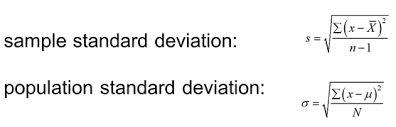 

ptp: Range of values (maximum - minimum) along an axis 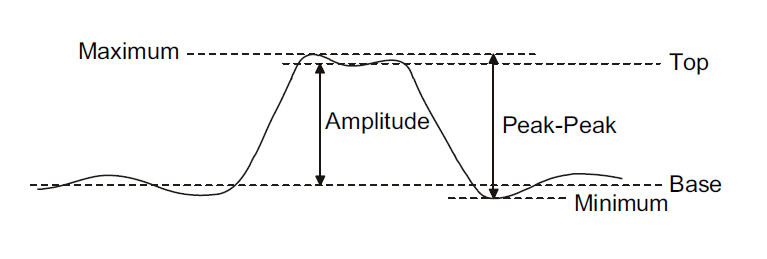

RMS: root mean square  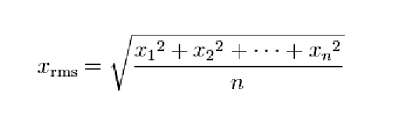

number of zero crossings: 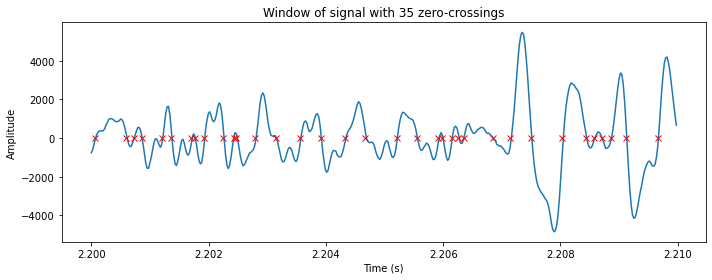

In [ ]:
# Extracting features
# Let's use the mean, min, max, std, peak-to-peak, RMS, and number of zero crossings of each channel as features, hence 6*7 features
features_per_class = [] 

for class_id in range(0, num_classes):
    num_windows = num_windows_per_class[class_id]
    sliding_windows = sliding_windows_per_class[class_id]
    features = [np.mean(sliding_windows, axis = 1), 
                np.min(sliding_windows, axis = 1),
                np.max(sliding_windows, axis = 1),
                np.std(sliding_windows, axis = 1),
                np.ptp(sliding_windows, axis = 1),
                np.sqrt(np.mean(sliding_windows**2, axis = 1)),
                np.count_nonzero(np.diff(np.sign(sliding_windows), axis = 1), axis = 1)]
    
    features = np.concatenate(features, axis = 1)
    features_per_class.append(features)

In [ ]:
features_per_class[0].shape


In [ ]:
# We now split the data into train, val and test sets
train_portion = 0.70
val_portion   = 0.15

num_windows_all_classes = np.sum(num_windows_per_class)

In [ ]:
int(2049*0.7)

In [ ]:
# Creating lists that will store the train, val and test portions of all classes
X_train = []
Y_train = []
X_val = []
Y_val = []
X_test = []
Y_test = []

for class_id in range(0, num_classes):
    num_windows = num_windows_per_class[class_id]
    num_windows_train = int(num_windows*train_portion)
    num_windows_val   = int(num_windows*val_portion)
    num_windows_test  = num_windows - num_windows_train - num_windows_val
    
    features = features_per_class[class_id]
    x_train, x_val, x_test = np.split(features, [num_windows_train, num_windows_train + num_windows_val], axis = 0)
    y_train, y_val, y_test = np.ones(num_windows_train)*class_id, np.ones(num_windows_val)*class_id, np.ones(num_windows_test)*class_id
    
    X_train.append(x_train)
    Y_train.append(y_train)
    
    X_val.append(x_val)
    Y_val.append(y_val)
    
    X_test.append(x_test)
    Y_test.append(y_test)

In [ ]:
print(X_train[0].shape)
print(X_train[1].shape)
print(X_train[2].shape)
print(X_train[3].shape)
print(X_train[4].shape)

In [ ]:
# Concatenating into a single array
X_train = np.concatenate(X_train, axis = 0)
Y_train = np.concatenate(Y_train, axis = 0)

X_val = np.concatenate(X_val, axis = 0)
Y_val = np.concatenate(Y_val, axis = 0)

X_test = np.concatenate(X_test, axis = 0)
Y_test = np.concatenate(Y_test, axis = 0)

In [ ]:
print(X_train.shape)

In [ ]:
# Logistic Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', C=0.01)
clf.fit(X_train, Y_train)
val_accuracy = clf.score(X_val, Y_val)*100
print(f"The validation accuracy for a Logistic Regression classifier: {val_accuracy:.2f}%")

In [ ]:
# Now let's create the KNN classifier
# We will loop through many different numbers of NN around sqrt(7982) ~= 89, where 7982 is the number of windows we have
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

for i in range(20, 99):
    num_neighbors = i
    clf = KNeighborsClassifier(n_neighbors=num_neighbors)
    clf.fit(X_train, Y_train)
    
    val_accuracy = clf.score(X_val, Y_val)*100
    print(f"The validation accuracy for a KNN classifier with K = {num_neighbors}: {val_accuracy:.2f}%")

In [ ]:
# Creating an SVM classifier with strategy set to OvO
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svm_clf = svm.SVC(kernel = 'linear')
print("Training classifier SVM OvO...")
svm_clf.fit(X_train, Y_train)

val_accuracy = svm_clf.score(X_val, Y_val)*100
print(f"The validation accuracy for a linear kernel and strategy OvO: {val_accuracy:.2f}%")

In [ ]:
# Creating an SVM classifier with strategy set to ovr
svm_clf = OneVsRestClassifier(svm.SVC(kernel = 'linear'))
print("Training classifier SVM OvR...")
svm_clf.fit(X_train, Y_train)

val_accuracy = svm_clf.score(X_val, Y_val)*100
print(f"The validation accuracy for a linear kernel and strategy OvR: {val_accuracy:.2f}%")

In [ ]:
# Creating an SVM classifier with strategy set to ovo, now with polynomial kernel
svm_clf = svm.SVC(kernel = 'poly')
print("Training classifier SVM OvO...")
svm_clf.fit(X_train, Y_train)

val_accuracy = svm_clf.score(X_val, Y_val)*100
print(f"The validation accuracy for a polynomial kernel and strategy OvO: {val_accuracy:.2f}%")

# Creating an SVM classifier with strategy set to ovr, now with polynomial kernel
svm_clf = OneVsRestClassifier(svm.SVC(kernel = 'poly'))
print("Training classifier SVM OvR...")
svm_clf.fit(X_train, Y_train)

val_accuracy = svm_clf.score(X_val, Y_val)*100
print(f"The validation accuracy for a polynomial kernel and strategy OvR: {val_accuracy:.2f}%")

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# resplit dataset
X_train_kfold = np.concatenate([X_train, X_val], axis = 0)
Y_train_kfold = np.concatenate([Y_train, Y_val], axis = 0)

# X_test = np.concatenate(X_test, axis = 0)
# Y_test = np.concatenate(Y_test, axis = 0)

# Define parameter grid for KNN
param_grid = {'n_neighbors': range(1, 21),
              'weights': ['uniform', 'distance'],
              'p': [1, 2] # p=1 for Manhattan distance, p=2 for Euclidean distance
}
print('10-fold cross-validation for selecting hyper-parameter')
# Perform 10-fold cross-validation
knn = KNeighborsClassifier()
cv = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_kfold, Y_train_kfold)

# Find and print the best parameters and best performance
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best parameters: {best_params}")
print(f"Best cross-validation accuracy: {best_score}")
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, Y_test)
print(f"Test set accuracy: {test_score}")

# # Best hyperparameter
# best_k = grid_search.best_params_['n_neighbors']
# print(f"Best number of neighbors: {best_k}")

# Train the model with the best hyperparameter
# best_knn = KNeighborsClassifier(n_neighbors=best_k)
# best_knn.fit(X_train, y_train)

# Make predictions
Y_pred = best_model.predict(X_test)

# Performance Metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='weighted')
recall = recall_score(Y_test, Y_pred, average='weighted')
f1 = f1_score(Y_test, Y_pred, average='weighted')
conf_matrix = confusion_matrix(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=set(Y_test), yticklabels=set(Y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

below code for next tutorial:

In [ ]:
# Let's go for a Random Forest now
# Our forest will have 25 decision trees
# We will use the maximum number of features 6
# We will use the OOB score to validate our random forest
# And let's set the maximum number of samples in each subset to be 5000

rf_clf = RandomForestClassifier(n_estimators=25, max_features=6, oob_score=True, max_samples=5000)

# Since we are using the OOB score to validate our tree, we do not need a validation set, so let's combine the training set with the validation set to create a new (and larger) training set
X_larger_train = np.concatenate([X_train, X_val], axis = 0)
Y_larger_train = np.concatenate([Y_train, Y_val], axis = 0)

rf_clf.fit(X_train, Y_train)

oob_score = rf_clf.oob_score_*100
print(f"The OOB score for the random forest: {oob_score:.2f}%")

# NOTE! It is not fair to compare the OOB score with the validation accuracy for the previous classifiers. Can you tell why?

In [ ]:
X_train.shape

In [ ]:
# Now it is time to create a neural network of type MLP (multi-layer perceptron)

# Data normalization. We obtain the mean and std on the training set
data_mean = np.mean(X_train, axis = 0)
data_std  = np.std(X_train, axis = 0)

# We normalize the sets using the mean and std found above
X_train = (X_train - data_mean)/data_std
X_val   = (X_val - data_mean)/data_std
X_test  = (X_test - data_mean)/data_std

# Now we shuffle the training data
indices = np.arange(0, X_train.shape[0])
random.shuffle(indices)
X_train = X_train[indices, ...]
Y_train = Y_train[indices, ...]

In [ ]:
# We create a classifier. Let's suppose we opt for 2 hidden layers, each of them with 30 neurons
clf_mlp = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=10000, learning_rate_init = 0.001, learning_rate = 'adaptive', activation = 'relu')
clf_mlp.fit(X_train, Y_train)

val_accuracy = clf_mlp.score(X_val, Y_val)*100
print(f"The validation accuracy for the MLP classifier: {val_accuracy:.2f}%")